In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import pickle
import statsmodels.stats.api as sms
import numpy as np

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
results = mlflow.search_runs()

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [4]:
for c in results.columns:
    if c[:7] == 'params.':
        results = results.rename(columns={c:c[7:]})
results = results.rename(columns={'metrics.f1_val' : 'f1_val', 'metrics.f1' : 'f1'})
results.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.roc', 'metrics.recall', 'metrics.accuracy',
       'metrics.precision', 'f1', 'f1_val', 'metrics.training_f1_score',
       'metrics.training_log_loss', 'metrics.training_precision_score',
       'metrics.training_accuracy_score', 'metrics.training_recall_score',
       'metrics.training_score', 'metrics.training_roc_auc', 'random_i',
       'model', 'stage', 'batch', 'epochs', 'units', 'dropout', 'activation',
       'preprocessing', 'model_selection', 'type', 'learning_rate', 'metric',
       'n_neighbors', 'kernel', 'C', 'n_estimators', 'min_samples_split',
       'criterion', 'random_state', 'max_depth', 'max_leaf_nodes', 'n_jobs',
       'class_weight', 'radius', 'ccp_alpha', 'min_weight_fraction_leaf', 'p',
       'min_samples_leaf', 'max_features', 'splitter', 'metric_params',
       'algorithm', 'min_impurity_decrease', 'leaf_size', 'estimator',
       'base_estimator', 'priors

# Experimento com treinamento e teste 80/20

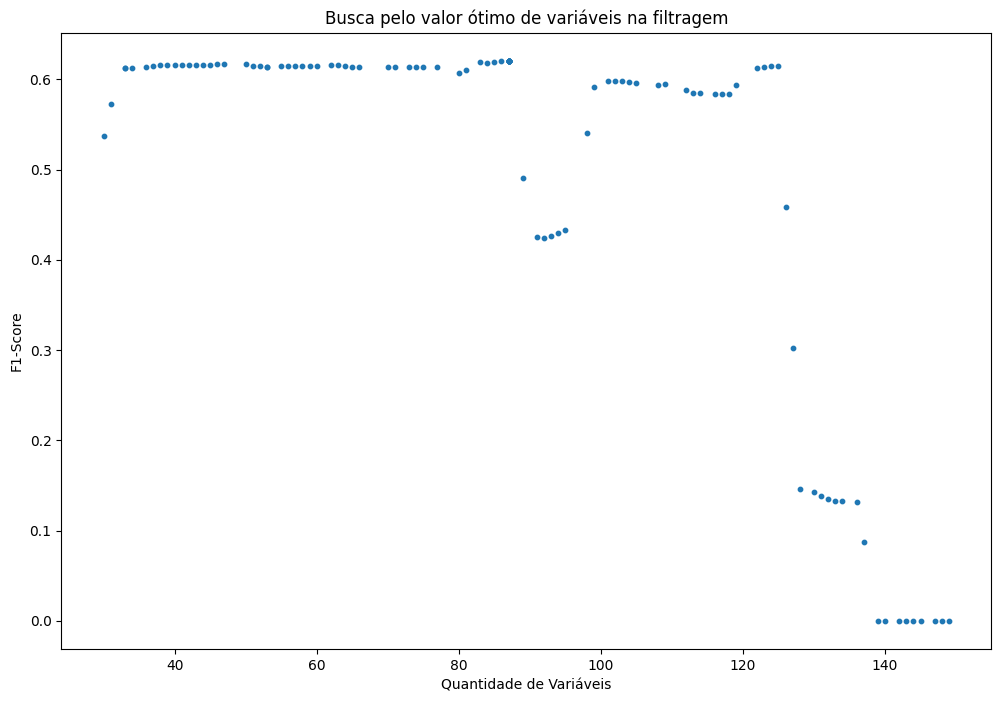

In [5]:
features_search = results[['features_i', 'f1_val', 'model_selection']].query('model_selection == "train_test"').dropna().sort_values(by='features_i', ascending=True)
features_search['features_i'] = features_search['features_i'].astype(int)
plt.scatter(features_search['features_i'], features_search['f1_val'], s=10)
plt.xlabel('Quantidade de Variáveis')
plt.ylabel('F1-Score')
plt.title('Busca pelo valor ótimo de variáveis na filtragem')
plt.show()

In [7]:
id = features_search['f1_val'].idxmax()
number_features = features_search['features_i'].loc[id]
print("O número de features encontradas é de: ", number_features)
# with open('../params/features.pkl', 'rb') as inp:
#    features = pickle.load(inp)
# print("As variáveis encontradas foram:", features)

O número de features encontradas é de:  87


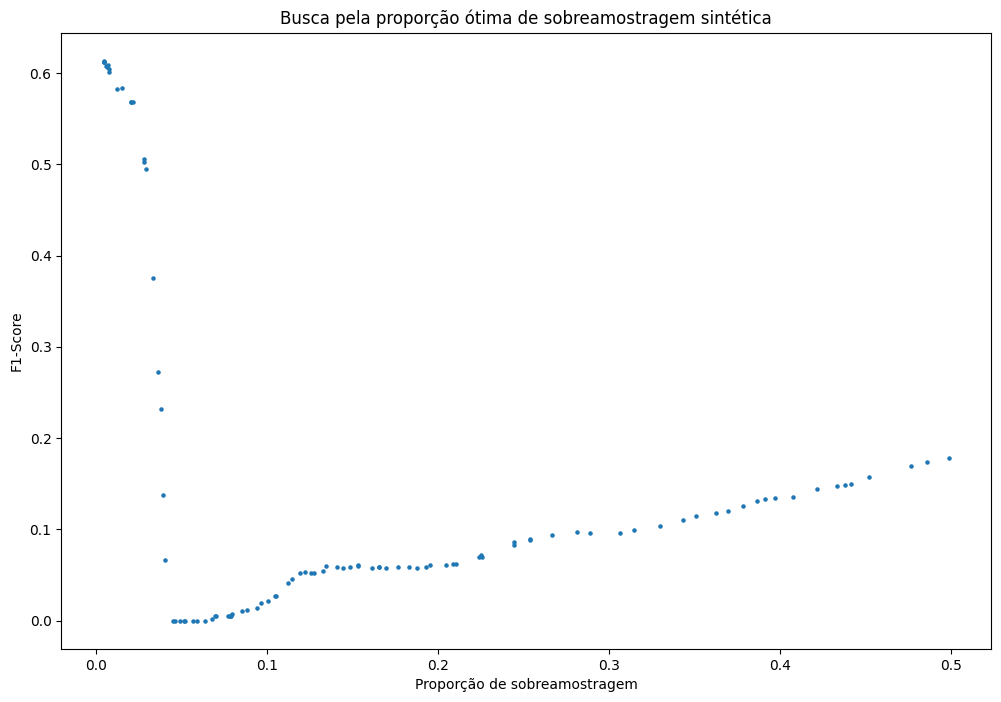

In [8]:
sampling_search = results[['sampling_strategy', 'f1_val', 'model_selection']].dropna()
sampling_search['sampling_strategy'] = sampling_search['sampling_strategy'].astype(float)
plt.scatter(sampling_search['sampling_strategy'], sampling_search['f1_val'], s=5)
plt.xlabel('Proporção de sobreamostragem')
plt.ylabel('F1-Score')
plt.title('Busca pela proporção ótima de sobreamostragem sintética')
plt.show()

In [10]:
with open('../data/params/smote.pkl', 'rb') as inp:
    var_smote = pickle.load(inp)
print("Proporção SMOTE:", var_smote)

Proporção SMOTE: 0.004664936141760721


In [11]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

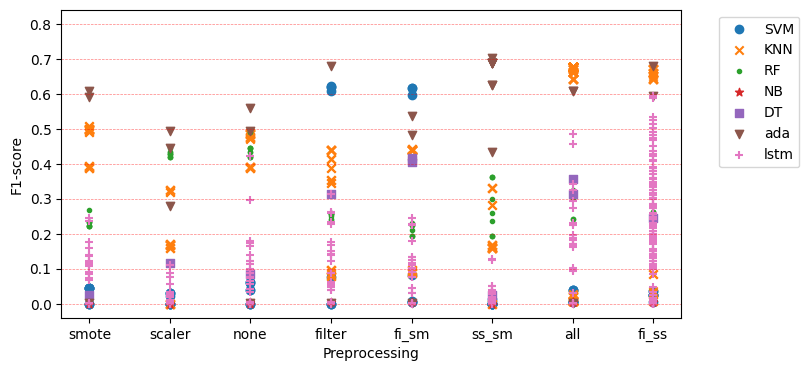

In [12]:
algo_search = results[['type', 'f1_val', 'preprocessing', 'model_selection']].query('model_selection == "train_test"').dropna()
plt.scatter(algo_search.query('type=="svm"')['preprocessing'], algo_search.query('type=="svm"')['f1_val'], marker='o', label='SVM')
plt.scatter(algo_search.query('type=="knn"')['preprocessing'], algo_search.query('type=="knn"')['f1_val'], marker='x', label='KNN')
plt.scatter(algo_search.query('type=="rf"')['preprocessing'], algo_search.query('type=="rf"')['f1_val'], marker='.', label='RF')
plt.scatter(algo_search.query('type=="nb"')['preprocessing'], algo_search.query('type=="nb"')['f1_val'], marker='*', label='NB')
plt.scatter(algo_search.query('type=="dt"')['preprocessing'], algo_search.query('type=="dt"')['f1_val'], marker='s', label='DT')
plt.scatter(algo_search.query('type=="ada"')['preprocessing'], algo_search.query('type=="ada"')['f1_val'], marker='v', label='ada')
plt.scatter(algo_search.query('type=="lstm"')['preprocessing'], algo_search.query('type=="lstm"')['f1_val'], marker='+', label='lstm') # plt.title('Comparison of Models Train/Val'), 
plt.xlabel('Preprocessing'), plt.ylabel('F1-score'), plt.legend(loc='upper center')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=.7, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.6, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.5, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.4, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.3, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.2, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.1, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.0, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=.8, color='r', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

In [13]:
grouped = results.query('model_selection == "train_test"').groupby('type')
indices_max = grouped['f1_val'].idxmax()
best_results = {}
# Para cada modelo, imprime os parâmetros correspondentes ao melhor resultado
for modelo, indice in indices_max.items():
    parametros = results.loc[indice, ['preprocessing', 'C', 'kernel',
                                      'n_estimators', 'n_neighbors', 'criterion',
                                      'var_smoothing', 'learning_rate', 'metric']]
    parametros = {chave: valor for chave, valor in parametros.to_dict().items() if type(valor) == str}
    # print(f"{modelo}: {results.loc[indice, 'f1_val']:.2f} (parâmetros: {parametros})")
    best_results[modelo] = parametros

for result in best_results:
    if result != 'knn':
        try: 
            del best_results[result]['n_neighbors']
            del best_results[result]['metric']
        except KeyError:
            pass
best_results

{'ada': {'preprocessing': 'ss_sm', 'n_estimators': '50', 'learning_rate': '1'},
 'dt': {'preprocessing': 'fi_sm', 'criterion': 'entropy'},
 'knn': {'preprocessing': 'all', 'n_neighbors': '1', 'metric': 'manhattan'},
 'lstm': {'preprocessing': 'fi_ss', 'learning_rate': '0.0006299586720690262'},
 'nb': {'preprocessing': 'none', 'var_smoothing': '1e-05'},
 'rf': {'preprocessing': 'none', 'n_estimators': '100'},
 'svm': {'preprocessing': 'filter', 'C': '1', 'kernel': 'rbf'}}

In [17]:
values = []
for v in features_search.index.values:
    values.append(v)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (0,).

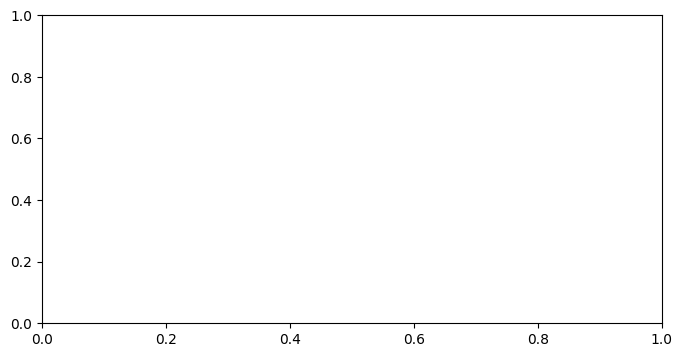

In [18]:
features_search = results[['model_selection', 'model', 'f1']].dropna().query('model_selection == "train_test"').groupby('model')['f1'].mean()
plt.bar(values, features_search.values, edgecolor='black', color='#4a95a5')
plt.xlabel('Models')
plt.ylabel('F1-Score')
g = 0
for i, v in enumerate(features_search.values):
    plt.text(i, v +.03, (str(round(v, 3)) + '±' + str(round(resultados['interval'].values[g], 3))),  fontweight='light', ha='center')
    g = g+1
plt.errorbar(values, features_search.values, resultados['interval'].values, fmt='none', ecolor='black', capsize=3)
plt.ylim(0, 1)
plt.show()

In [17]:
features_search = results[['model_selection', 'model', 'roc']].dropna().query('model_selection == "train_test"').groupby('model')['roc'].mean()
plt.bar(features_search.index, features_search.values)
plt.xlabel('Modelos')
plt.ylabel('ROC-AUC')
plt.title('Busca pelo valor ótimo de variáveis na filtragem')
for i, v in enumerate(features_search.values):
    plt.text(i, v, str(v),  fontweight='bold', ha='center')
plt.show()

KeyError: "['roc'] not in index"

In [19]:
analise_intervalo = results.query("stage == 'statistics_analysis'")[['model', 'f1']]
models = analise_intervalo['model'].unique()
data = {'model':[], 'mean':[], 'interval':[]}
for model in models:
    query = f"model == '{model}'"
    data['model'].append(model)
    data['mean'].append(np.mean(analise_intervalo.query(query)['f1']))
    interval = sms.DescrStatsW(analise_intervalo.query(query)['f1']).tconfint_mean()
    data['interval'].append(interval[1]-interval[0])
resultados = pd.DataFrame(data)
resultados

,model,mean,interval
0,lstm,0.0,0.0
